In this assignment you will learn how to apply the REINFORCE algorithm within the OpenAI Gym environment. Make sure OpenAI gym is installed on your machine. Now let's import some relevant packages.

In [ ]:
# Group number: 24
# Franka Buytenhuijs, s4356845
# Hugo Chateau-Laurent, s1023970
# Maria Tsfasman, s1021505

In [1]:
import gym
from gym import wrappers, logger
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import chainer
from chainer import Chain
import chainer.links as L
import chainer.functions as F
from chainer.optimizers import Adam
from chainer import Variable
import IPython
from IPython.display import clear_output

import time

%matplotlib inline

We will make use of the classic CartPole environment provided by OpenAI Gym. Figure out what the details of this environment are.

In [2]:
env_id = 'CartPole-v0'

# You can set the level to logger.DEBUG or logger.WARN if you want to change the amount of output.
logger.set_level(logger.INFO)

In [3]:
env = gym.make(env_id)
env.reset()

done = False
for step in range(1000):
    #env.render()
    done = env.step(env.action_space.sample())[2]
    if done:
        env.reset()
    step+=1
    #time.sleep(0.01)

env.close()

INFO: Making new env: CartPole-v0


Let's define a baseline agent which just emits random actions.

In [4]:
class RandomAgent(object):
    """The world's simplest agent!"""

    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, observation, reward, done):
        return self.action_space.sample()


Let's run the agent on the environment.

In [5]:
env = gym.make(env_id)
env.seed(0)
agent = RandomAgent(env.action_space)

episode_count = 1000
done = False
reward = 0

R0 = np.zeros(episode_count)
for i in tqdm.trange(episode_count):

    ob = env.reset()

    while True:
        #env.render()
        action = agent.act(ob, reward, done)
        ob, reward, done, _ = env.step(action)

        R0[i] += reward

        if done:
            break

# Close the env and write monitor result info to disk
env.close()

INFO: Making new env: CartPole-v0


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3165.01it/s]


Let's create the REINFORCE agent. We assume that the policy is computed using an MLP with a softmax output.

In [14]:
class MLP(Chain):
    """Multilayer perceptron"""

    def __init__(self, n_output=1, n_hidden=5):
        super(MLP, self).__init__(l1=L.Linear(None, n_hidden), l2=L.Linear(n_hidden, n_output))

    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))

1: A skeleton for the REINFORCEAgent is given. Implement the compute_loss and compute_score functions. 

In [15]:
class REINFORCEAgent(object):
    """Agent trained using REINFORCE"""

    def __init__(self, action_space, model, optimizer=Adam()):

        self.action_space = action_space

        self.model = model

        self.optimizer = optimizer
        self.optimizer.setup(self.model)

        # monitor score and reward
        self.rewards = []
        self.scores = []


    def act(self, observation, reward, done):

        # linear outputs reflecting the log action probabilities and the value
        policy = self.model(Variable(np.atleast_2d(np.asarray(observation, 'float32'))))

        # generate action according to policy
        p = F.softmax(policy).data

        # normalize p in case tiny floating precision problems occur
        row_sums = np.sum(p, axis=1)
        p /= row_sums[:, np.newaxis]

        action = np.asarray([np.random.choice(p.shape[1], None, True, p[0])])

        return action, policy


    def compute_loss(self):
        """
        Return loss for this episode based on computed scores and accumulated rewards
        """
        
        J = 0
        for t in range(len(self.scores)):
            Q_hat = sum(self.rewards[t:])
            Q_hat = Q_hat * self.scores[t]
            J -= Q_hat
    
        return J

    def compute_score(self, action, policy):
        """
        Computes score

        Args:
            action (int):
            policy:

        Returns:
            score
        """
        score = F.softmax(policy)
        score = F.log(score[0, action])
        return score


Now we run the REINFORCE agent on the CartPole environment. Note that we update the agent after each episode for simplicity.

In [ ]:
env = gym.make(env_id)
env.seed(0)

network = MLP(n_output=env.action_space.n, n_hidden=3)
agent = REINFORCEAgent(env.action_space, network, optimizer=Adam(0.01))

episode_count = 1000
R = np.zeros(episode_count)
reward = 0
weights = np.copy(agent.model.l2.W.data)

losses = []
done = False

for i in tqdm.trange(episode_count):

    ob = env.reset()
    agent.rewards = []
    agent.scores = []

    while True:

        action, policy = agent.act(ob, reward, done)
        #action = np.asarray([action])
        ob, reward, done, _ = env.step(action[0])

        # get reward associated with taking the previous action in the previous state
        agent.rewards.append(reward)
        R[i] += reward

        # recompute score function: grad_theta log pi_theta (s_t, a_t) * v_t
        agent.scores.append(agent.compute_score(action, policy))

    # we learn at the end of each episode
        if done:
            loss = agent.compute_loss()
            losses.append(loss.data)
            agent.model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            agent.optimizer.update()
            clear_output()

            plt.plot(range(i+1), losses)
            plt.title('Loss')
            plt.show()
            weights_new = np.copy(agent.model.l2.W.data)
            print(weights-weights_new)
            plt.imshow(np.absolute(weights-weights_new), interpolation='None', cmap='gray')
            plt.colorbar()
            weights = weights_new
            plt.title('Delta weights')
            plt.show()

            break


In [ ]:
# You may want to run a video of the trained agent performing in the environment using the env.render() function.

for i in range(3):

    ob = env.reset()

    while True:

        action, policy = agent.act(ob, reward)

        ob, reward, done, _ = env.step(action)

        if done:
            break
      
        env.render()

2: Plot the cumulative reward for both RandomAgent and REINFORCEAgent.

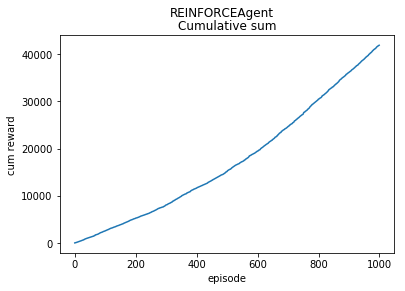

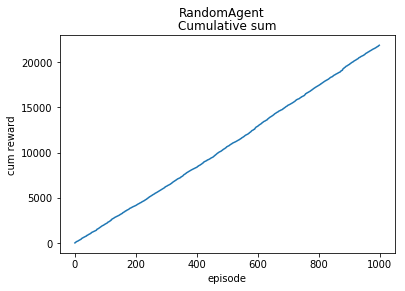

In [10]:
import matplotlib.pylab as plt
plt.figure(1)
plt.suptitle('REINFORCEAgent')
plt.title('Cumulative sum')
plt.xlabel('episode')
plt.ylabel('cum reward')
plt.plot(np.cumsum(R))

plt.figure(2)
plt.suptitle('RandomAgent')
plt.title('Cumulative sum')
plt.xlabel('episode')
plt.ylabel('cum reward')
plt.plot(np.cumsum(R0))